In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
# ------------------ Time-LLM (Causal Transformer) ------------------
class TimeLLM(nn.Module):
    def __init__(self, n_features, d_model=128, n_heads=4, num_layers=3, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(n_features, d_model)
        encoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerDecoder(encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(d_model, 1)  # Predict next value

    def forward(self, x):
        x_embed = self.input_linear(x)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x_embed.size(1)).to(x.device)
        out = self.transformer(tgt=x_embed, memory=x_embed, tgt_mask=causal_mask)
        return self.output_linear(out)[:, -1, 0]  # predict next step


In [10]:
# ------------------ Dataset Preparation ------------------
def create_autoregressive_sequences(X_data, y_data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len])
    return np.array(X_seq), np.array(y_seq)


In [11]:
# ------------------ Inference Function (Autoregressive Forecast) ------------------
def autoregressive_forecast(model, scaler, X_test, features, seq_len, forecast_horizon):
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    X_test_np = X_test_scaled.values

    forecasts = []
    for i in tqdm(range(len(X_test_np) - seq_len - forecast_horizon), desc="Forecasting"):
        input_window = X_test_np[i:i+seq_len].copy()
        forecast_seq = []
        
        for step in range(forecast_horizon):
            input_tensor = torch.tensor(input_window[np.newaxis,:,:], dtype=torch.float32)
            with torch.no_grad():
                pred = model(input_tensor).item()
            forecast_seq.append(pred)
            
            next_row = np.append(input_window[-1][:-1], pred)
            input_window = np.vstack([input_window[1:], next_row])
        forecasts.append(forecast_seq)
    return np.array(forecasts)


In [12]:
# ------------------ Desequencing Function ------------------
def desequence_autoregressive(predictions, seq_len, forecast_horizon):
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast

In [13]:
def autoregressive_forecast_on_sequences(model, X_seq_sliced, forecast_horizon):
    model.eval()
    forecasts = []

    with torch.no_grad():
        for i in range(len(X_seq_sliced)):
            input_seq = torch.tensor(X_seq_sliced[i], dtype=torch.float32).unsqueeze(0)  # add batch dim
            forecast = model(input_seq).numpy()
            forecasts.append(forecast)

    forecasts = np.array(forecasts).squeeze()
    return forecasts


In [45]:
def evaluate_two_timellm_models(
    model_orig, model_aug, scaler, X_test, y_test, features, 
    seq_len, forecast_horizon, time_index=None, start_point=0, end_point=None
):
    # Get predictions for both models
    forecasts_orig = autoregressive_forecast(model_orig, scaler, X_test, features, seq_len, forecast_horizon)
    merged_pred_orig = desequence_autoregressive(forecasts_orig, seq_len, forecast_horizon)

    forecasts_aug = autoregressive_forecast(model_aug, scaler, X_test, features, seq_len, forecast_horizon)
    merged_pred_aug = desequence_autoregressive(forecasts_aug, seq_len, forecast_horizon)

    # Scale test data
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    valid_indices = len(X_test_scaled) - seq_len - forecast_horizon
    X_seq, y_seq = create_autoregressive_sequences(X_test_scaled, y_test, seq_len)
    y_seq = y_seq[:valid_indices]  
    merged_true = desequence_autoregressive(np.expand_dims(y_seq, axis=1), seq_len, forecast_horizon)

    # Apply slicing
    merged_true = merged_true[start_point:end_point]
    merged_pred_orig = merged_pred_orig[start_point:end_point]
    merged_pred_aug = merged_pred_aug[start_point:end_point]

    # Metrics
    mse_orig = mean_squared_error(merged_true, merged_pred_orig)
    mae_orig = mean_absolute_error(merged_true, merged_pred_orig)
    rmse_orig = math.sqrt(mse_orig)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"Shuffle Model - MSE: {mse_orig:.4f}, MAE: {mae_orig:.4f}, RMSE: {rmse_orig:.4f}")
    print(f"No Shuffle Model - MSE: {mse_aug:.4f}, MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # Prepare time index
    if time_index is not None:
        time_index = time_index[-len(merged_true):]
        plot_range = time_index
    else:
        plot_range = range(len(merged_true))

    if end_point is None:
        end_point = len(merged_true)

    plt.figure(figsize=(16, 6))
    
    # Historical window (before forecast)
    plt.plot(plot_range[start_point:start_point+seq_len], 
             merged_true[start_point:start_point+seq_len], 
             label='Input History', color='blue', linewidth=2)
    
    # Actual future
    plt.plot(plot_range[start_point:end_point], 
             merged_true[start_point:end_point], 
             label='Actual Future', color='black')
    
    # Forecasts
    plt.plot(plot_range[start_point:end_point], 
             merged_pred_orig[start_point:end_point], 
             label='Shuffle Model Forecast', color='red', linestyle='--')
    
    plt.plot(plot_range[start_point:end_point], 
             merged_pred_aug[start_point:end_point], 
             label='No Shuffle Model Forecast', color='green', linestyle=':')

    # Shade between Actual and Original Forecast (pink)
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_true[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        where=(merged_true[start_point:end_point] >= merged_pred_orig[start_point:end_point]),
        interpolate=True, color='pink', alpha=0.5, label='Error (Actual - Shuffled)'
    )
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        merged_true[start_point:end_point], 
        where=(merged_true[start_point:end_point] < merged_pred_orig[start_point:end_point]),
        interpolate=True, color='pink', alpha=0.5
    )

    # Shade between Original Forecast and Augmented Forecast (light blue)
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        merged_pred_aug[start_point:end_point], 
        where=(merged_pred_aug[start_point:end_point] >= merged_pred_orig[start_point:end_point]),
        interpolate=True, color='lightblue', alpha=0.5, label='Difference (Shuffled - No Shuffled)'
    )
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_pred_aug[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        where=(merged_pred_aug[start_point:end_point] < merged_pred_orig[start_point:end_point]),
        interpolate=True, color='lightblue', alpha=0.5
    )

    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("Time-LLM Forecast Comparison: shuffled vs No Shuffled")
    plt.legend()
    plt.grid(True)

    textstr = (
        f'Shuffle Model\nMAE: {mae_orig:.4f}\nRMSE: {rmse_orig:.4f}\n'
        f'No Shuffle Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


In [38]:
import joblib

In [39]:
seq_len = 24
forecast_horizon = 12


X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])
y_test = org_test_processed[target]

In [40]:
model_path  = "../Models/weights/time_llm_org_no_shuffle_model.pth_20"


In [41]:
model_timellm_no_shuffle = TimeLLM(len(features))
# Load model state_dict
model_path  ="../Models/weights/time_llm_org_no_shuffle_model.pth_20"
model_timellm_no_shuffle.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_timellm_no_shuffle.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/scaler_timellm_aug.pkl'
scaler_timellm_aug = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.


In [42]:
model_timellm_org = TimeLLM(len(features))
# Load model state_dict
model_path  = "../Models/weights/time_llm_org_model.pth_20"
model_timellm_org.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_timellm_org.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/scaler_timellm_org.pkl'
scaler_timellm_org = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.



Evaluating TimeLLM on test data...


Forecasting:   0%|          | 0/707 [00:00<?, ?it/s]

Forecasting: 100%|██████████| 707/707 [00:14<00:00, 49.75it/s]


Shuffle Model - MSE: 0.0027, MAE: 0.0369, RMSE: 0.0520
No Shuffle Model - MSE: 0.0043, MAE: 0.0491, RMSE: 0.0659


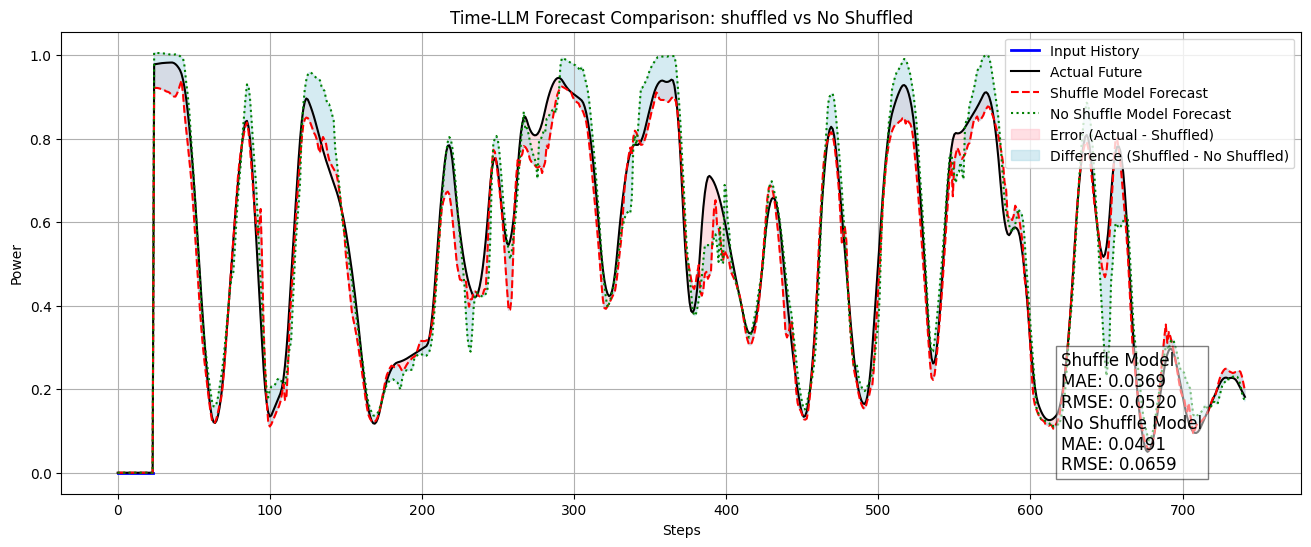

Forecasting: 100%|██████████| 707/707 [00:14<00:00, 48.08it/s]


Shuffle Model - MSE: 0.0011, MAE: 0.0227, RMSE: 0.0335
No Shuffle Model - MSE: 0.0018, MAE: 0.0332, RMSE: 0.0428


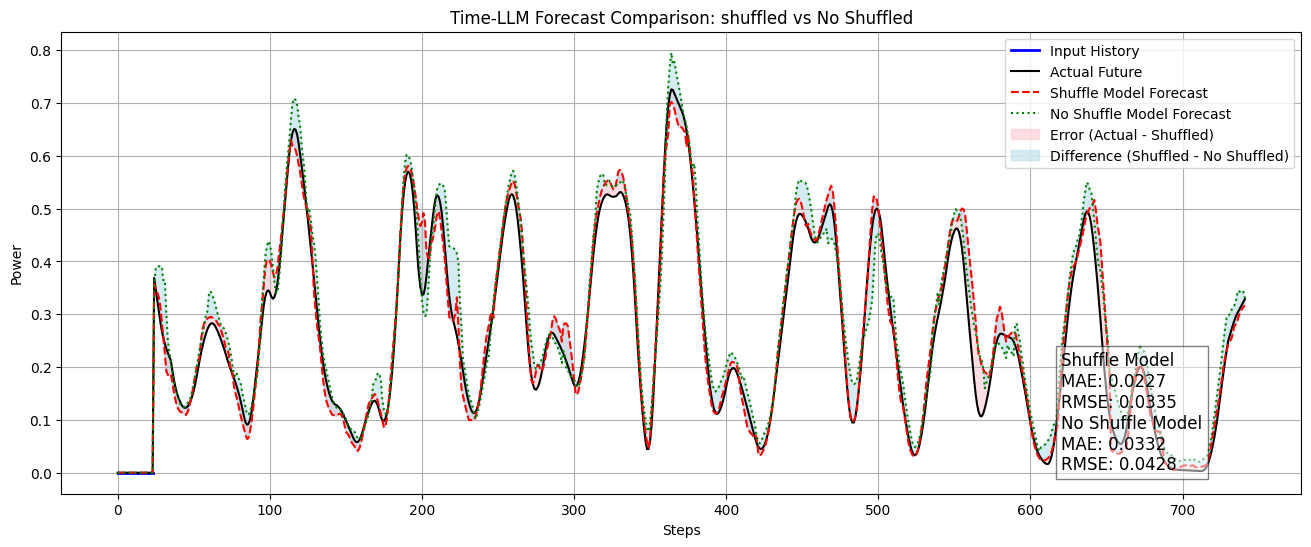

Forecasting: 100%|██████████| 707/707 [00:13<00:00, 51.69it/s]


Shuffle Model - MSE: 0.0100, MAE: 0.0661, RMSE: 0.1002
No Shuffle Model - MSE: 0.0117, MAE: 0.0734, RMSE: 0.1082


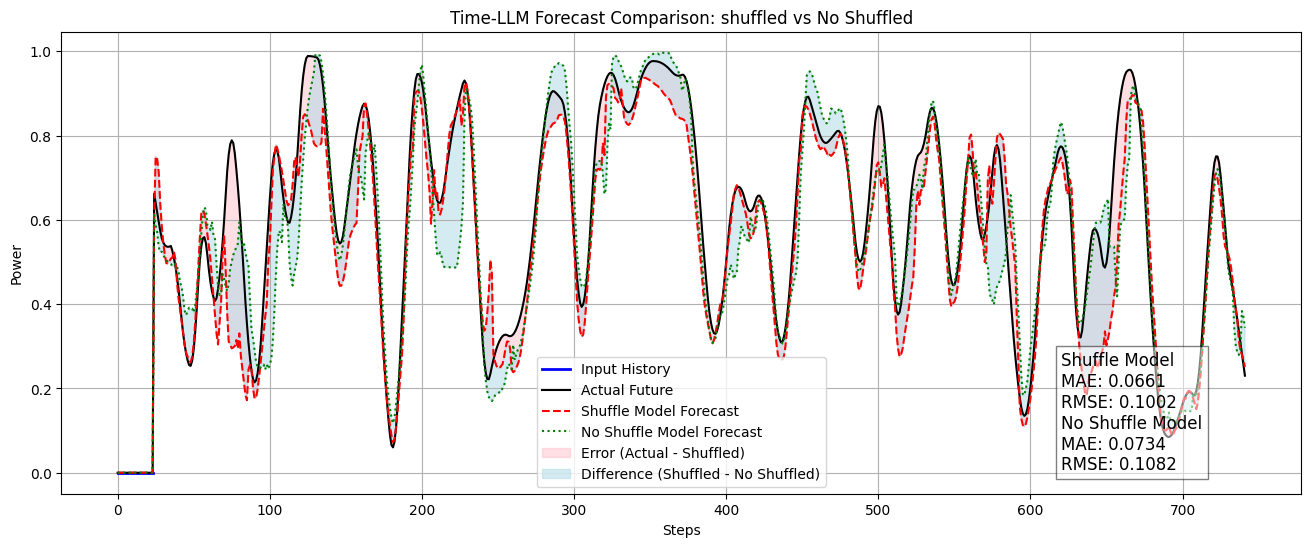

Forecasting: 100%|██████████| 707/707 [00:13<00:00, 52.38it/s]


Shuffle Model - MSE: 0.0023, MAE: 0.0287, RMSE: 0.0475
No Shuffle Model - MSE: 0.0030, MAE: 0.0401, RMSE: 0.0550


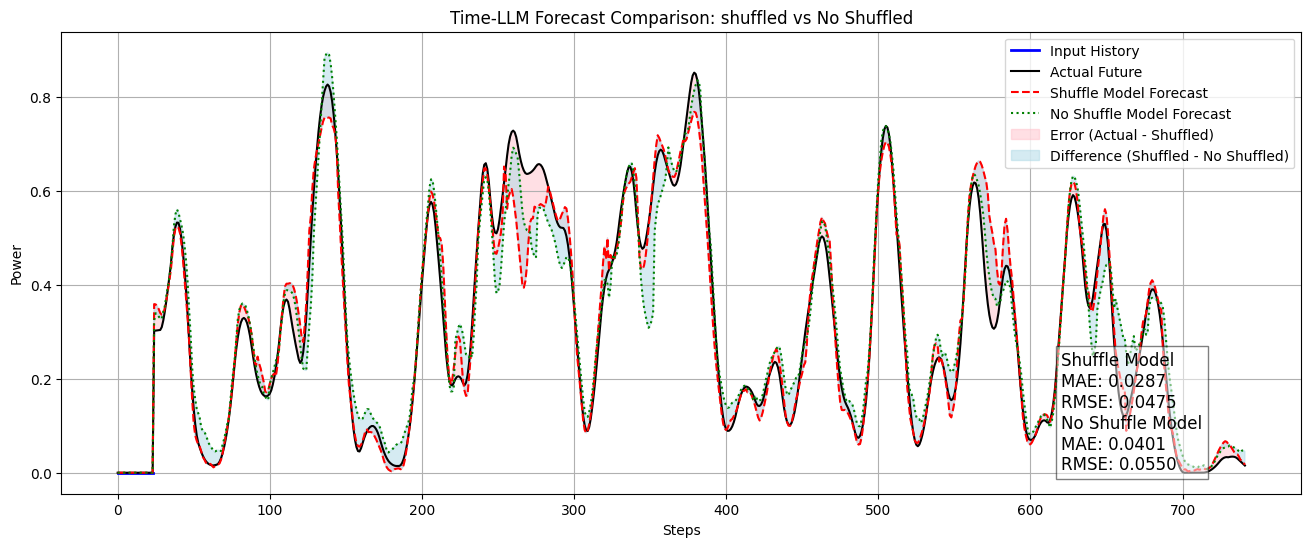

In [46]:
print("\nEvaluating TimeLLM on test data...")
start_point=7991
end_point=8734
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug=model_timellm_no_shuffle, scaler= scaler_timellm_aug, X_test= X_test[start_point:end_point], y_test= y_test[start_point:end_point],features= features, seq_len=seq_len, forecast_horizon=forecast_horizon)
start_point=16726
end_point=17469
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug= model_timellm_no_shuffle, scaler= scaler_timellm_aug,X_test=  X_test[start_point:end_point],y_test= y_test[start_point:end_point],features= features, seq_len=seq_len, forecast_horizon=forecast_horizon)
start_point=25461
end_point=26204
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug= model_timellm_no_shuffle, scaler= scaler_timellm_aug, X_test= X_test[start_point:end_point],y_test= y_test[start_point:end_point],features= features,seq_len= seq_len, forecast_horizon=forecast_horizon)
start_point=34196
end_point=34939
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug= model_timellm_no_shuffle, scaler= scaler_timellm_aug, X_test= X_test[start_point:end_point],y_test= y_test[start_point:end_point],features= features,seq_len= seq_len, forecast_horizon= forecast_horizon)


In [47]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math 

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100


def evaluate_monthly_timemoe_errors(
    model_orig, model_aug, 
    scaler_X, y_train_org,
    X_test, y_test, features,
    seq_len
):
    # Prepare index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    # Scale full test set
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=features)

    # Inverse scaler for target
    y_scaler = StandardScaler().fit(y_train_org.values.reshape(-1, 1))

    # Location slicing
    total_len = len(X_test)
    n_locations = 4
    loc_size = total_len // n_locations

    results = []

    for loc in range(n_locations):
        start_idx = loc * loc_size
        end_idx = (loc + 1) * loc_size

        # Data for this location
        X_loc = X_test_scaled.iloc[start_idx:end_idx]
        y_loc = y_test.iloc[start_idx:end_idx]

        for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
            y_month = y_loc[df_month.index]

            if len(df_month) < seq_len + 1:
                continue

            # Create sequences
            X_seq, y_seq = create_autoregressive_sequences(df_month[features],y_month, seq_len)
            if len(X_seq) == 0:
                continue

            X_tensor = torch.tensor(X_seq, dtype=torch.float32)

            # Predict
            with torch.no_grad():
                model_orig.eval()
                model_aug.eval()
                preds_orig = model_orig(X_tensor).numpy()
                preds_aug = model_aug(X_tensor).numpy()

            # Inverse transform
            y_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
            preds_orig_inv = y_scaler.inverse_transform(preds_orig.reshape(-1, 1)).flatten()
            preds_aug_inv = y_scaler.inverse_transform(preds_aug.reshape(-1, 1)).flatten()

            # Compute metrics
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_shuffle': mean_absolute_error(y_true, preds_orig_inv),
                'rmse_shuffle': math.sqrt(mean_squared_error(y_true, preds_orig_inv)),
                'mape_shuffle': mape(y_true, preds_orig_inv),
                'smape_shuffle': smape(y_true, preds_orig_inv),
                'r2_shuffle': r2_score(y_true, preds_orig_inv),
                'mae_no_shuffle': mean_absolute_error(y_true, preds_aug_inv),
                'rmse_no_shuffle': math.sqrt(mean_squared_error(y_true, preds_aug_inv)),
                'mape_no_shuffle': mape(y_true, preds_aug_inv),
                'smape_no_shuffle': smape(y_true, preds_aug_inv),
                'r2_no_shuffle': r2_score(y_true, preds_aug_inv)
            })

    results_df = pd.DataFrame(results)

    # Monthly average + std across 4 locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_shuffle': ['mean', 'std'],
        'rmse_shuffle': ['mean', 'std'],
        'mape_shuffle': ['mean', 'std'],
        'smape_shuffle': ['mean', 'std'],
        'r2_shuffle': ['mean', 'std'],
        'mae_no_shuffle': ['mean', 'std'],
        'rmse_no_shuffle': ['mean', 'std'],
        'mape_no_shuffle': ['mean', 'std'],
        'smape_no_shuffle': ['mean', 'std'],
        'r2_no_shuffle': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]

    return results_df, monthly_summary


In [48]:
results_df, monthly_summary = evaluate_monthly_timemoe_errors(
    model_orig=model_timellm_org,
    model_aug=model_timellm_no_shuffle,
    scaler_X=scaler_timellm_aug,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    features=features,
    seq_len=seq_len
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7389/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7389/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7389/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7389/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):


In [50]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_shuffle': f"{loc_data['mae_shuffle'].mean():.4f}  ± {loc_data['mae_shuffle'].std():.4f}",
        'rmse_shuffle': f"{loc_data['rmse_shuffle'].mean():.4f}  ± {loc_data['rmse_shuffle'].std():.4f}",
        'mape_shuffle': f"{loc_data['mape_shuffle'].mean():.4f}  ± {loc_data['mape_shuffle'].std():.4f}",
        'smape_shuffle': f"{loc_data['smape_shuffle'].mean():.4f}  ± {loc_data['smape_shuffle'].std():.4f}",
        'r2_shuffle': f"{loc_data['r2_shuffle'].mean():.4f}  ± {loc_data['r2_shuffle'].std():.4f}",
        'mae_no_shuffle': f"{loc_data['mae_no_shuffle'].mean():.4f}  ± {loc_data['mae_no_shuffle'].std():.4f}",
        'rmse_no_shuffle': f"{loc_data['rmse_no_shuffle'].mean():.4f}  ± {loc_data['rmse_no_shuffle'].std():.4f}",
        'mape_no_shuffle': f"{loc_data['mape_no_shuffle'].mean():.4f}  ± {loc_data['mape_no_shuffle'].std():.4f}",
        'smape_no_shuffle': f"{loc_data['smape_no_shuffle'].mean():.4f}  ± {loc_data['smape_no_shuffle'].std():.4f}",
        'r2_no_shuffle': f"{loc_data['r2_no_shuffle'].mean():.4f}  ± {loc_data['r2_no_shuffle'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_shuffle': f"{results_df['mae_shuffle'].mean():.4f}  ± {results_df['mae_shuffle'].std():.4f}",
    'rmse_shuffle': f"{results_df['rmse_shuffle'].mean():.4f}  ± {results_df['rmse_shuffle'].std():.4f}",
    'mape_shuffle': f"{results_df['mape_shuffle'].mean():.4f}  ± {results_df['mape_shuffle'].std():.4f}",
    'smape_shuffle': f"{results_df['smape_shuffle'].mean():.4f}  ± {results_df['smape_shuffle'].std():.4f}",
    'r2_shuffle': f"{results_df['r2_shuffle'].mean():.4f}  ± {results_df['r2_shuffle'].std():.4f}",
    'mae_no_shuffle': f"{results_df['mae_no_shuffle'].mean():.4f}  ± {results_df['mae_no_shuffle'].std():.4f}",
    'rmse_no_shuffle': f"{results_df['rmse_no_shuffle'].mean():.4f}  ± {results_df['rmse_no_shuffle'].std():.4f}",
    'mape_no_shuffle': f"{results_df['mape_no_shuffle'].mean():.4f}  ± {results_df['mape_no_shuffle'].std():.4f}",
    'smape_no_shuffle': f"{results_df['smape_no_shuffle'].mean():.4f}  ± {results_df['smape_no_shuffle'].std():.4f}",
    'r2_no_shuffle': f"{results_df['r2_no_shuffle'].mean():.4f}  ± {results_df['r2_no_shuffle'].std():.4f}",
})
final_results =  pd.DataFrame(final_results)

In [51]:
final_results

,Location,mae_shuffle,rmse_shuffle,mape_shuffle,smape_shuffle,r2_shuffle,mae_no_shuffle,rmse_no_shuffle,mape_no_shuffle,smape_no_shuffle,r2_no_shuffle
0,Location_1,0.0115 ± 0.0033,0.0173 ± 0.0049,2.6428 ± 0.6128,2.6473 ± 0.6291,0.9357 ± 0.0312,0.0161 ± 0.0039,0.0231 ± 0.0057,3.7516 ± 0.7556,3.7388 ± 0.7479,0.8870 ± 0.0490
1,Location_2,0.0110 ± 0.0035,0.0172 ± 0.0054,2.9935 ± 0.8937,2.9301 ± 0.8542,0.8336 ± 0.0637,0.0150 ± 0.0028,0.0203 ± 0.0044,4.1383 ± 0.6341,4.0505 ± 0.6396,0.7686 ± 0.0650
2,Location_3,0.0129 ± 0.0069,0.0198 ± 0.0103,3.2668 ± 1.3893,3.2379 ± 1.3965,0.7213 ± 0.1967,0.0167 ± 0.0064,0.0227 ± 0.0094,4.3965 ± 1.2219,4.3191 ± 1.2172,0.4493 ± 0.8725
3,Location_4,0.0095 ± 0.0019,0.0148 ± 0.0030,2.4700 ± 0.4188,2.4466 ± 0.4189,0.9021 ± 0.0660,0.0127 ± 0.0027,0.0176 ± 0.0041,3.3412 ± 0.5880,3.3007 ± 0.5895,0.8699 ± 0.0697
4,All Location Combined,0.0112 ± 0.0044,0.0173 ± 0.0065,2.8433 ± 0.9301,2.8154 ± 0.9229,0.8482 ± 0.1346,0.0151 ± 0.0044,0.0209 ± 0.0064,3.9069 ± 0.9060,3.8523 ± 0.8952,0.7437 ± 0.4609


In [52]:
monthly_summary

,month,mae_shuffle_mean,mae_shuffle_std,rmse_shuffle_mean,rmse_shuffle_std,mape_shuffle_mean,mape_shuffle_std,smape_shuffle_mean,smape_shuffle_std,r2_shuffle_mean,...,mae_no_shuffle_mean,mae_no_shuffle_std,rmse_no_shuffle_mean,rmse_no_shuffle_std,mape_no_shuffle_mean,mape_no_shuffle_std,smape_no_shuffle_mean,smape_no_shuffle_std,r2_no_shuffle_mean,r2_no_shuffle_std
0,2021-01,0.008047,0.000935,0.012072,0.002442,2.134551,0.395632,2.109685,0.371079,0.911917,...,0.012962,0.002244,0.018734,0.003528,3.494311,0.747185,3.425698,0.682527,0.823864,0.157070
1,2021-02,0.010904,0.002293,0.017687,0.003984,2.811491,0.462977,2.777999,0.460383,0.840251,...,0.012959,0.001968,0.018392,0.004599,3.420542,0.524191,3.369853,0.478639,0.841813,0.102932
2,2021-03,0.011801,0.004410,0.017060,0.006156,2.860000,0.643292,2.865172,0.675505,0.906452,...,0.016718,0.004126,0.022521,0.006806,4.279320,0.720056,4.185880,0.692556,0.815866,0.093799
3,2021-04,0.013270,0.004289,0.020305,0.007224,3.496117,1.371413,3.408061,1.238676,0.787686,...,0.018361,0.002716,0.024782,0.002000,4.860187,1.030468,4.738087,0.952715,0.742308,0.127695
4,2021-05,0.010817,0.001560,0.016678,0.001790,2.870479,0.295966,2.830199,0.289537,0.817147,...,0.014856,0.003275,0.020811,0.005876,3.985064,0.668533,3.926853,0.671814,0.740972,0.192333
5,2021-06,0.008166,0.001381,0.013159,0.002127,2.196898,0.222965,2.178801,0.226676,0.817626,...,0.012604,0.001480,0.016681,0.002757,3.485751,0.311690,3.419936,0.294959,0.756614,0.252724
6,2021-07,0.007381,0.002733,0.012272,0.005217,2.053153,0.678020,2.006452,0.652030,0.741320,...,0.011173,0.001577,0.014849,0.003109,3.167102,0.240933,3.118075,0.252931,0.052607,1.549432
7,2021-08,0.009061,0.003071,0.013364,0.004529,2.523090,0.819283,2.483759,0.795362,0.853573,...,0.012390,0.003829,0.016726,0.004847,3.468877,1.029697,3.418773,1.015587,0.775707,0.115799
8,2021-09,0.012143,0.001281,0.020097,0.002836,3.111662,0.296348,3.059908,0.247254,0.865135,...,0.014528,0.001137,0.020277,0.002588,3.728786,0.346859,3.684240,0.304208,0.856705,0.053672
9,2021-10,0.010521,0.003237,0.015785,0.005012,2.551980,0.760646,2.538388,0.752839,0.934512,...,0.014130,0.003793,0.020055,0.006423,3.511733,0.944043,3.492862,0.943923,0.897218,0.087620


In [53]:
FOLDER_NAME = './Results/TimeLLM'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)